In [1]:
import numpy as np
import matplotlib.pyplot as plt
 
class Nacaxxxx: 
    def __init__(self,digits):
        self.digits=digits
        self.m=float(self.digits[0])*.01                                        #camber
        self.p=float(self.digits[1])*.1                                         #max camber location 
        self.t=float(self.digits[2:])*.01                                       #max thickness
 
    def camber(self,x):                                                         #function to calculate camber 
        m=self.m
        p=self.p
        if m==0:
            return 0
        if x<=p :
            return (m/p**2)*(2*p*x-x**2)
        else:
            return (m/(1-p)**2)*(1-2*p+2*p*x-x**2) 
    
    def thickness(self,x):                                                      #function to calculate thickness 
        m=self.m        
        p=self.p
        t=self.t
        return (5*t)*(0.2969*x**0.5-0.126*x-0.3516*x**2+0.2843*x**3-0.1036*x**4)
    
    def z_u(self,x):                                                            #function to calculate upper surface coordinates
        Zu = self.camber(x)+self.thickness(x)
        print("upper coordinate: ", Zu)
        return self.camber(x)+self.thickness(x)
        
 
    def z_l(self,x):                                                            #function to calculate lower surface coordinates 
        Zl = self.camber(x)-self.thickness(x)
        print("lower coordinate: ", Zl)
        return self.camber(x)-self.thickness(x)
        


#**1a.Linear Vortex Panel Method**
<ol><li>This cell contains a class to solve the $Linear\; Vortex \;Panel\; Method$ to compute Cl, Cm with the help of pressure co efficents and circulation densities.
<li>In this cell, arrays corresponding to nodes, panels, panel width,panel anlges ,control points, normals and tangents, influence coefficients are initially filled with zeros
<li>The class contains corresponding functions(i.e. methods) to solve the above defined terms.
<li>Notations: single underscore determines subscript(i.e.node,  x_i=$x_i$) and double underscore determines superscript(i.e. panel, x__i=$x^i$) in the code.
<li>The $Bonus \; part$ of the assignment (i.e that calculates the Cm in the Linear vortex panel method) is also included in this class for the ease of results arrangment.


In [2]:
class Vortex_panel_2D:
    def __init__(self,m,z_u,z_l):
        self.m=m                                                                #No. of panels
 
        self.z_u=z_u                                                            # upper surface co-ordinates
        self.z_l=z_l                                                            # lower surface co-ordinates
  
        self.x_j=np.zeros(m+1)                                                  # 1-D, m+1 size array of zeros for nodes of x- coordinates
        self.z_j=np.zeros(m+1)                                                  # 1-D, m+1 size array of zeros for nodes of x- coordinates
        self.node_coordinates()                                                 # funtion defined to calculte nodes
 
        self.l__j=np.zeros(m)                                                   # 1-D, m size array of zeros for lengths of individual panels
        self.panel_widths()                                                     #funtion defined to calculte panel width
        
        self.x__i=np.zeros(m)                                                   #1-D, m size array of zeros for control points of individual panels
        self.z__i=np.zeros(m)                                                   #1-D, m size array of zeros for control points of individual panels
        self.control_points()                                                   #funtion defined to calculate control points
 
        self.theta=np.zeros(m)                                                  #1-D, m size array of zeros for panle angles of individual panels
        self.panel_angles()                                                     #funtion defined to panel angles
 
        self.n__i=np.zeros((m,2))                                               #2-D, (m rows & 2 columns ) array of zeros for unit normals
        self.t__i=np.zeros((m,2))                                               #2-D, (m rows & 2 columns ) array of zeros for unit tangents
        self.panel_normals_tangents()                                           #funtion defined to calculate both unit normals and unit tangent
 
        self.c_ij__n1=np.zeros((m,m))                                           #2-D, (m rows & m columns ) array of zeros for Influence coefficients Cn1
        self.c_ij__n2=np.zeros((m,m))                                           #2-D, (m rows & m columns ) array of zeros for Influence coefficients Cn2
        self.c_ij__t1=np.zeros((m,m))                                           #2-D, (m rows & m columns ) array of zeros for Influence coefficients Ct1
        self.c_ij__t2=np.zeros((m,m))                                           #2-D, (m rows & m columns ) array of zeros for Influence coefficients Ct2
        self.normal_tangential_influence_coefficients()                         #funtion defined to calculate both normal and  tangential influence coefficients
        self.c_p__i=np.zeros(m)                                                 #funtion to calculate coefficients of pressure
 
    def node_coordinates(self):
        m=self.m
        z_u=self.z_u
        z_l=self.z_l
        x_j=self.x_j
        z_j=self.z_j
 
        thetas = np.linspace(-1,1,m+1)*np.pi                                    #clock wise notation -pi to pi (TE lower surface to TE upper surface )
 
        lower_nodes=0                                                           #nodes of lower surfaces
        for i in range(0,thetas.size):
            if thetas[i]<=0:
                lower_nodes+=1                                                  #determinig the number of lower nodes
    
        x_j = 0.5*(1 - np.cos(thetas))                                          #glauert form
 
        for j in range(0,lower_nodes):
            z_j[j] = z_l(x_j[j])                                                #lower surface nodes
 
        for j in range(lower_nodes,m+1): 
            z_j[j] = z_u(x_j[j])                                                #upper surface nodes

        self.x_j=x_j
        self.z_j=z_j
        print("division of circle: ", thetas)
        print("X node coordinate is : ", self.x_j)
        print("Z node coordinate is : ", self.z_j)
        
    def panel_widths(self):                                                     #funtion to calculate width of the panel
        m=self.m
        x_j=self.x_j
        z_j=self.z_j
        l__j=self.l__j
        
        for j in range(0,m):
            l__j[j]=( (x_j[j+1]-x_j[j])**2 + (z_j[j+1]-z_j[j])**2 )**0.5        #width of the panel
        
        
        self.l__j=l__j
        print("length of panel: ", self.l__j)
 
    def control_points(self):                                                   #funtion defined to calculate control points
        m=self.m
        x_j=self.x_j
        z_j=self.z_j
        x__i=self.x__i
        z__i=self.z__i
 
        for i in range(0,m):
            x__i[i]=( x_j[i+1] + x_j[i] )/2                                     #control points X-coordinate
            z__i[i]=( z_j[i+1] + z_j[i] )/2                                     #control points Z-coordinate

        self.x__i=x__i
        self.z__i=z__i

    def panel_angles(self):                                                     #funtion defined to calculate panel angles
        m=self.m 
        x_j=self.x_j
        z_j=self.z_j
        theta=self.theta
 
        for j in range(0,m):
             theta[j]=np.arctan2( (z_j[j+1]-z_j[j]) , (x_j[j+1]-x_j[j]) )       #panel angle
        
        self.theta=theta
        print("theta_panel is : ", self.theta)
 
    def panel_normals_tangents(self):                                           #funtion defined to calculate both unit normals and unit tangent
        m=self.m
        x_j=self.x_j
        z_j=self.z_j
        theta=self.theta
        n__i=self.n__i
        t__i=self.t__i
 
        for i in range(0,m):                                                    #n=-sin(theta)i+cos(theta)k
            n__i[i][0]=-np.sin(theta[i])  
            n__i[i][1]=np.cos(theta[i])   
 
        for i in range(0,m):                                                    #t= cos(theta)i+sin(theta)k
            t__i[i][0]=np.cos(theta[i])
            t__i[i][1]=np.sin(theta[i])
        
        self.n__i=n__i
        self.t__i=t__i
 
    def normal_tangential_influence_coefficients(self):                         #funtion defined to calculate both normal and  tangential influence coefficients
        m=self.m
        x_j=self.x_j
        z_j=self.z_j
        x__i=self.x__i
        z__i=self.z__i
        theta=self.theta
        l__j=self.l__j
        c_ij__n1=self.c_ij__n1                                                  #Cn1
        c_ij__n2=self.c_ij__n2                                                  #Cn2
        c_ij__t1=self.c_ij__t1                                                  #Ct1
        c_ij__t2=self.c_ij__t2                                                  #Ct2
 
        for i in range(0,m):                                                    #calculating  the terms A,B,C,D,E,F,G,P,Q                                             
            for j in range(0,m):
                if i==j:
                    c_ij__t1[i][j]=np.pi/2                                      #diagonal elements are pi/2 for Ct1 (2-D array,size=mXm)
                    c_ij__t2[i][j]=np.pi/2                                      #diagonal elements are pi/2 for Ct2 (2-D array,size=mXm)
                    c_ij__n1[i][j]=-1                                           #diagonal elements are -1 for Cn1   (2-D array,size=mXm)
                    c_ij__n2[i][j]=1                                            #diagonal elements are 1 for Cn2    (2-D array,size=mXm)
                else:
                    a= -( (x__i[i]-x_j[j]) * np.cos(theta[j]) ) - ( (z__i[i]-z_j[j]) * np.sin(theta[j]) )                  #A
                    b= (x__i[i]-x_j[j])**2 + (z__i[i]-z_j[j])**2                                                           #B
                    c= np.sin(theta[i]-theta[j])                                                                           #C
                    d= np.cos(theta[i]-theta[j])                                                                           #D
                    e= ((x__i[i]-x_j[j])*np.sin(theta[j])) - ((z__i[i]-z_j[j])*np.cos(theta[j]))                           #E
                    f= np.log(1+((l__j[j]**2)+(2*l__j[j]*a))/b)                                                            #F
                    g= np.arctan2((e*l__j[j]),(b+a*l__j[j]))                                                               #G
                    p= (((x__i[i]-x_j[j])*(np.sin(theta[i]-2*theta[j])))+((z__i[i]-z_j[j])*(np.cos(theta[i]-2*theta[j])))) #P
                    q= (((x__i[i]-x_j[j])*(np.cos(theta[i]-2*theta[j])))-((z__i[i]-z_j[j])*(np.sin(theta[i]-2*theta[j])))) #Q
 
                    c_ij__n2[i][j]= d + 0.5*q*f/l__j[j] - (a*c+d*e)*g/l__j[j]   #Cn2
                    c_ij__n1[i][j]= 0.5*d*f + c*g - c_ij__n2[i][j]              #Cn1
 
                    c_ij__t2[i][j]= c + (0.5*p*f)/l__j[j] + (a*d-c*e)*g/l__j[j] #Ct2
                    c_ij__t1[i][j]= 0.5*c*f - d*g - c_ij__t2[i][j]              #Ct1

        print("value of coeff1:", c_ij__n1)
        print("value of coeff2:", c_ij__n2)
        self.c_ij__n1=c_ij__n1
        self.c_ij__n2=c_ij__n2
        self.c_ij__t1=c_ij__t1
        self.c_ij__t2=c_ij__t2
 
       
    def solve(self,alpha):                                                      #funtion to solve vortex panel densities  
        m=self.m
        x__i=self.x__i
        z__i=self.z__i
        theta=self.theta
        l__j=self.l__j
        n__i=self.n__i
        c_ij__n1=self.c_ij__n1
        c_ij__n2=self.c_ij__n2
        c_ij__t1=self.c_ij__t1
        c_ij__t2=self.c_ij__t2
        c_p__i=self.c_p__i
        
        matrix_a=np.zeros((m+1,m+1))                                            # matrix A in AX=B form ,A  (i.e.coefficinet matrix)
        matrix_b=np.zeros(m+1)                                                  # B(i.e constant vector) and X  will be unknown vector
 
        for i in range(0,m):                                                    #filling up the  Matrix-A (2-D array, size=(m+1)X(m+1)) 
            for j in range(0,m+1):
                if j==0:
                    matrix_a[i][j]=c_ij__n1[i][j]
 
                elif j==m:
                    matrix_a[i][j]=c_ij__n2[i][j-1]
 
                else:                
                    matrix_a[i][j]=c_ij__n2[i][j-1] + c_ij__n1[i][j]
 
        matrix_a[m][0]=1                                                        #A[m+1,1]=1 and A[m+1,j]=0 where j_in:[2;m]:
        matrix_a[m][m]=1                                                        #A[m+1,m+1]=1 (i.e. Kutta condition)
        
        print("W matrx is: ", matrix_a)
        
        for i in range(0,m):
            matrix_b[i]=np.sin(theta[i]-alpha)                                  #B(i.e constant vector)= sin(theta- alpha) 
        
        matrix_b[m]=0
        print("jeeta matrix is : ", matrix_b)

        
 
        gamma=np.linalg.solve(matrix_a,matrix_b)                                #solving for linear equations in a matrix AX=B (i.e Wn=E)
                                                                             
                                                                                #Computation of surface pressure coefficient
        print("gamma value: ", gamma)
        
        matrix_c=np.zeros((m,m+1))                                              # matrix C in CY=D form ,C  (i.e.coefficinet matrix)
        matrix_d=np.zeros(m)                                                    #D(i.e constant vector) and Y will be unknown vector
        for i in range(0,m):                                                    ##filling up the  Matrix-C (2-D array, size=(m+1)X(m+1)) 
            for j in range(0,m+1):
                if j==0:
                    matrix_c[i][j]=c_ij__t1[i][j]
                elif j==m:
                    matrix_c[i][j]=c_ij__t2[i][j-1]
                else:
                    matrix_c[i][j]=c_ij__t2[i][j-1]+c_ij__t1[i][j]
 
        for i in range(0,m):
            matrix_d[i]=np.cos(theta[i]-alpha)    
        
        v_t__i=matrix_d+np.dot(matrix_c,gamma)                                  #V_ti/V_freestream
        
        for i in range(0,m):
            c_p__i[i]=1-v_t__i[i]**2                                            #surface pressure coefficient
             
        f_x = - np.sum(c_p__i*self.l__j*self.n__i[:,0])                         #Normal component force
        f_z = - np.sum(c_p__i*self.l__j*self.n__i[:,1])                         #Axial component of force
        c_l_p = f_z*np.cos(alpha) - f_x*np.sin(alpha)                           #Lift=Ncos(a)-Asin(a) by Cp 
        
        sum=0
        for j in range(0,m):
            sum+=(gamma[j]+gamma[j+1])*l__j[j]                                  #gamma[i]= circulation desitites correspondif to individual panels
 
        c_l=2*np.pi*sum                                                         #lift coefficient by circulation densities
        
        thetas = np.linspace(-1,1,m)*np.pi                                      # theta range for Cm of each panel
        il = np.where(thetas <= 0)[0]                                           #tells the index of the element for lower surface panels
        iu = np.where(thetas > 0)[0]                                            #tells the index of the element for upper surface panels

        m_1=np.sum(c_p__i[iu]*l__j[iu]*n__i[iu,1]*x__i[iu]) 
        m_2=np.sum(c_p__i[iu]*l__j[iu]*n__i[iu,0]*z__i[iu])
        m_3=np.sum(c_p__i[il]*l__j[il]*n__i[il,1]*x__i[il])
        m_4=np.sum(c_p__i[il]*l__j[il]*n__i[il,0]*z__i[il])
        
        c_m=m_1+m_2+m_3+m_4+c_l_p/4                                             #Cm(c/4)
        
        print("pressure coeff: ", c_p__i)
        return c_l,c_l_p,c_m


# **1b.Hess-Smith method**
<ol><li>This cell contains a class to solve the $Hess-Smith$ Method to compute Cl, Cm with the help of pressure co efficents and circulation densities.
<li>Similar procedure to calculate the required terms corresponding to the Hess-Smith method are incorporated in the following cell.
<li> Results for both LVPM and Hess-Smith method are shown after the cell.
<li>The $Bonus \; part$ of the assignment (i.e that calculates the Cm in the Hess-Smith method) is also included in this class for the ease of results arrangment.


In [3]:
class Hess_smith(Vortex_panel_2D):                                              #Hess and smith method
    
    def solve(self,alpha): #funtion 
        m=self.m
        x__i=self.x__i
        x_j=self.x_j
        z__i=self.z__i
        theta=self.theta
        l__j=self.l__j
        c_ij__n1=self.c_ij__n1 
        c_ij__n2=self.c_ij__n2
        c_ij__t1=self.c_ij__t1
        c_ij__t2=self.c_ij__t2
        c_p__i=self.c_p__i
        n__i=self.n__i
 
        a_ij__n=c_ij__n1+c_ij__n2                                               #An=Cn1+Cn2 where An=0.5DF+CG
        a_ij__t=c_ij__t1+c_ij__t2                                               #At=Ct1+Ct2 where At=0.5CF-DG
 
        for i in range(0,m):
            for j in range(0,m):
                if i==j:
                   a_ij__t[i][j]=np.pi                                          #Diagonal elements  of At are pi
                   a_ij__n[i][j]=0                                              #Diagonal elements  of An are 0
 
        e_ij__n=a_ij__t                                                         #EETAn= At 
        e_ij__t=-a_ij__n                                                        #EETAt= -An
 
        matrix_z=np.zeros((m+1,m+1))                                            #matrix A in ZE=X form ,A  (i.e.coefficinet matrix)                                    
        matrix_x=np.zeros(m+1)                                                  #X(i.e constant vector) and E  will be unknown vector
 
        for i in range(0,m+1):
            for j in range(0,m):
                if i==m:
                    matrix_z[i][j]=e_ij__t[0][j]+e_ij__t[m-1][j]
                    matrix_z[m][m]+=a_ij__t[0][j]+a_ij__t[m-1][j]
                
                else: 
                    matrix_z[i][j]=e_ij__n[i][j]
                    matrix_z[i][m]+=a_ij__n[i][j]
 
        for i in range(0,m):
            matrix_x[i]=np.sin(theta[i]-alpha)                                  #xi = sin(thetai -alpha)
 
        matrix_x[m]=-np.cos(theta[0]-alpha)-np.cos(theta[m-1]-alpha)            #X(i.e constant vector) 
 
        eeta=np.linalg.solve(matrix_z,matrix_x)                                 #solving for linear equations in a matrix ZE=X
        print("eeta matrix: ", eeta)
        v_t__i=np.zeros(m)                                                      #V_ti/V_freestream array woth zeros
 
        for i in range(0,m):
            v_t__i[i]=np.cos(theta[i]-alpha)
            for j in range(0,m):
                v_t__i[i]+=e_ij__t[i][j]*eeta[j]+a_ij__t[i][j]*eeta[m]          #V_ti/V_freestream after solving the EETA and 
 
        
 
        for i in range(0,m):
            c_p__i[i]=1-v_t__i[i]**2                                            #Computation of surface pressure coefficient
        
        f_x = - np.sum(c_p__i*l__j*n__i[:,0])
        f_z = - np.sum(c_p__i*l__j*n__i[:,1])
        c_l_p = f_z*np.cos(alpha) - f_x*np.sin(alpha)                           #Lift=Ncos(a)-Asin(a) by Cp 
                               
        sum=0
        for j in range(0,m):
            sum+=2*(eeta[m])*l__j[j]
 
        c_l=2*np.pi*sum                                                         #lift coefficient by circulation densities
           
        thetas=np.linspace(-1,1,m)*np.pi                                        #theta range for Cm of each panel
        il=np.where(thetas<=0)[0]                                               #tells the index of the element for lower surface panels
        iu=np.where(thetas>0)[0]                                                #tells the index of the element for upper surface panels

        m_1=np.sum(c_p__i[iu]*l__j[iu]*n__i[iu,1]*x__i[iu])                     #bonus part (Cm Hess_smith)
        m_2=np.sum(c_p__i[iu]*l__j[iu]*n__i[iu,0]*z__i[iu])
        m_3=np.sum(c_p__i[il]*l__j[il]*n__i[il,1]*x__i[il])
        m_4=np.sum(c_p__i[il]*l__j[il]*n__i[il,0]*z__i[il])

        c_m=m_1+m_2+m_3+m_4+c_l_p/4                                             #Cm(c/4)
        
        print("eeta matrix: ", eeta)
        print("hs Cp values are: ", c_p__i)
        return c_l,c_l_p,c_m

airfoil=Nacaxxxx("0000")
 


In [4]:
airfoil=Nacaxxxx(input("Enter the Naca 4 digit series: "))                                   #object of Nacaxxxx class

m=int(input("Enter the number of panels: "))                                    #Number of panels

alpha=float(input("Enter the angle of attack in degrees: "))                    #Angle of attack  in degrees


pfoil1=Vortex_panel_2D(m,airfoil.z_u,airfoil.z_l)                               #object of Vortex_panel_2D class
pfoil2=Hess_smith(m,airfoil.z_u,airfoil.z_l)                                    #object of  Hess_smith class
pfoil1.solve(alpha*np.pi/180)
c_l,c_l_p,c_m=pfoil1.solve(alpha*np.pi/180)                                     #calling the solve function with LVPM
print("------Linear vortex panel method-----")
print("C_l from pressure coefficients : ",c_l_p)
print("C_l  from   vortex  densities  : ",c_l)
print("C_m_0.25c from pressure coefficients : ",c_m)

c_l,c_l_p,c_m=pfoil2.solve(alpha*np.pi/180)                                     #calling the solve function with Hess smith method
print("-----Hess and Smith panel method-----") 
print("C_l from pressure coefficients : ",c_l_p)
print("C_l  from   vortex  densities  : ",c_l)
print("C_m_0.25c from pressure coefficients : ",c_m)


lower coordinate:  4.718447854656916e-17
lower coordinate:  -0.001521210065338632
lower coordinate:  -0.006014956159340372
lower coordinate:  -0.013279370030883721
lower coordinate:  -0.02300200272994176
lower coordinate:  -0.03478953709401007
lower coordinate:  -0.04819860200328816
lower coordinate:  -0.06276058690764179
lower coordinate:  -0.07799546331197033
lower coordinate:  -0.0934131846791124
lower coordinate:  -0.10850530176631734
lower coordinate:  -0.1227328760179508
lower coordinate:  -0.13551860641704355
lower coordinate:  -0.1462507060690556
lower coordinate:  -0.15430343885673503
lower coordinate:  -0.15907491251522274
lower coordinate:  -0.1600377529606063
lower coordinate:  -0.1567939123945597
lower coordinate:  -0.1492043271907176
lower coordinate:  -0.1379821781008295
lower coordinate:  -0.12320218696550712
lower coordinate:  -0.10487075094631432
lower coordinate:  -0.08313682865733535
lower coordinate:  -0.0582399187810344
lower coordinate:  -0.030448102948411715
low

#**Part-2 Demonstration of Results and Discussion**

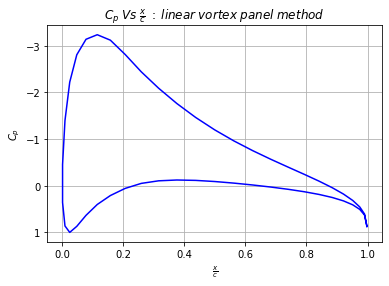

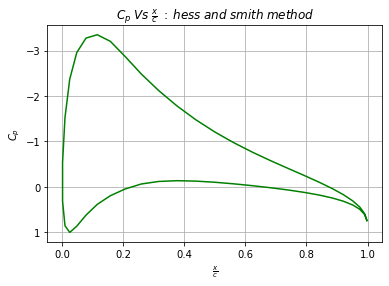

In [5]:
x__i=pfoil1.x__i                                                                #similar & repeated plotting commands for representing  the results
z__i=pfoil1.z__i
c_p__i_lvpm=pfoil1.c_p__i
c_p__i_hs=pfoil2.c_p__i
 
plt.figure(1)
plt.plot(x__i,c_p__i_lvpm,'b')
plt.gca().invert_yaxis()
plt.xlabel(r'$\frac{x}{c}$')
plt.ylabel(r'$C_p$')
plt.title(r'$C_p \; Vs \; \frac{x}{c}\; :\;linear\;vortex\;panel\;method$')
plt.grid(True)
 
plt.figure(2)
plt.plot(x__i,c_p__i_hs,'g')
plt.gca().invert_yaxis()
plt.xlabel(r'$\frac{x}{c}$')
plt.ylabel(r'$C_p$')
plt.title(r'$C_p \; Vs \; \frac{x}{c}\; :\;hess\;and\;smith\;method$')
plt.grid(True)
 


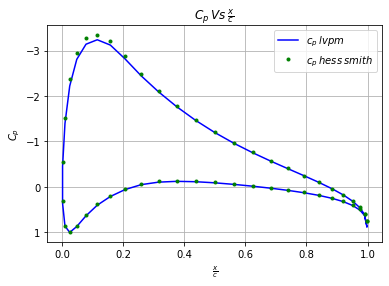

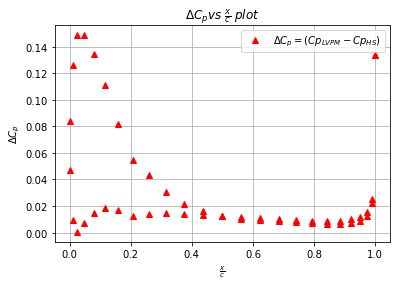

In [6]:
plt.figure(3)
plt.plot(x__i,c_p__i_lvpm,'b',x__i,c_p__i_hs,'g.',)
plt.legend(["$c_{p}\:lvpm$","$c_{p}\:hess\:smith$"])
plt.gca().invert_yaxis()
plt.ylabel(r"$C_p$")
plt.xlabel(r"$\frac{x}{c}$")
plt.title(r"$C_p\:Vs\:\frac{x}{c}$")
plt.grid(True)
 
plt.figure(4)
plt.plot(x__i,(abs(c_p__i_lvpm-c_p__i_hs)),'r^')
plt.ylabel(r"$\Delta C_p$")
plt.xlabel(r"$\frac{x}{c}$")
plt.title(r"$\Delta C_p vs\ \frac{x}{c} \;plot$")
plt.legend([r"$\Delta C_p= (Cp_{LVPM}-Cp_{HS})$"])
plt.grid(True)

###Results:
<ol><li>We find that $C_l$ obtained from $circulation\; densities$ being more close to x-foil data for a given number of  in both LVPM and HS methods.
<li>We also find that $C_{m\frac{c}{4}}$ is almost close with values obtained from xfoil.
<li>As we increase the number of panels the results for both Linear vortex panel method(LVPM) and Hess-Smith(HS) method come close to each other. However, we have observed that the LVPM requires comparatively lesser number of panels (i.e. lesser runtime of code) to get the results close to Experimental data. 

<li>The linear function that governs the Vortex densities across a panel's length gives more accurate results at the node points. However the HS method can be fairly close to the LVPM method by increasing the number of panels because of which the function governing the Vortex Density Distribution will have lesser impact in the calculations.
<li>We see that the $linear\; vortex\; panel \;method$ predicts more closely the flow at trailing edge and leading edge for a given number of panels.


#**Part-3**
<ol><li>We choose the following airfoils for study NACA 00XX, NACA 14XX, NACA 24XX and NACA 44XX for the angle of attack in range of $-15^o \;to \;23^o $.
<li>First the camber of the airfoil is fixed and its thickness varies from 6 to 24 in an interval of 2.
<li>Hence each value of camber is analysed at 10 different thickness values and threre are 4 such cambers (i.e.00XX,14XX,24XX,44XX) which ends up with analysing $4\times10=40$ different airfoils.
<li>The lift curve slopes obtained from both  $Linear\; Vortex \;Panel\; Method$ and $Hess-Smith \; Method$ are plotted for each aifoil

In [7]:
airfoils=np.array(["00","14","24","44"])                                        #array for first two digits
thickness=np.array(["06","08","10","12","14","16","18","20","22","24"])         #array for last two digits
c_l1=np.zeros((4,10,20))
c_l2=np.zeros((4,10,20))

alpha=np.linspace(-15,23,20)
def master(n):                                                                  #funtion to run the required claculations of Cl in loops for several airfoils as described in arrays
    for  i in range(0,4):
        digit=""
        for  j in range(0,10):
            digit=airfoils[i]
            digit=digit+thickness[j]                                            #concatenation of first two and last two digits

    
            airfoil=Nacaxxxx(digit)                                             #Decoding the airfoil nomenclature

            pfoil1=Vortex_panel_2D(n,airfoil.z_u,airfoil.z_l)                   #using LVPM class  
            pfoil2=Hess_smith(n,airfoil.z_u,airfoil.z_l)                        #using Hess smith class
            #print('>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Airfoil:',digit,'<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<')
            #print("---------------------------------------------LVPM--------------------------------------------------------------------------HS----------------------------")
            
            for  k in range(0,20):
           
                c_lg1,c_lp1,c_m1=pfoil1.solve(alpha[k]*np.pi/180)               #result of LVPM class 
                c_l1[i][j][k]=c_lg1
                c_lg2,c_lp2,c_m2=pfoil2.solve(alpha[k]*np.pi/180)               #result of Hess smith class
                c_l2[i][j][k]=c_lg2

                #print('AoA',alpha[k],'------------Cl:',c_lg1,'------------Cm',c_m1,'-----------Cl',c_lg2,'-----------Cm',c_m2)


In [8]:
def zero_lift_aoa():
    from scipy.interpolate import interp1d                                      #interpolating to find zero lift AoA 
    zero_lift_aoa1=np.zeros((4,10))                                             #array of zeros ( for LVPM) 
    thickness=np.array(["06","08","10","12","14","16","18","20","22","24"])     #range of thickness values
    zero_lift_aoa2=np.zeros((4,10))                                             #array of zeros ( for Hess-Smith) 
    for i in range(0,4):                                                        #nested loop to find Zero lift AoA of every airfoil described in arrays
        for j in range(0,10):
            f1=interp1d(c_l1[i][j][ : ],alpha)
            zero_lift_aoa1[i][j]=f1(0)                                          #locates where  cl intercepts 0 in LVPM          
            f2=interp1d(c_l2[i][j][ : ],alpha)
            zero_lift_aoa2[i][j]=f2(0)                                          #locates where  cl intercepts 0 in=hess smith method
            #print(zero_lift_aoa1[i][j],'----',zero_lift_aoa2[i][j])               
       

    plt.figure(1)                                                               #similar & repeated plotting commands for representing  the results
    plt.plot(thickness,zero_lift_aoa1[0],'bo',thickness,zero_lift_aoa2[0],'r^')
    plt.legend(['lvpm','hess and smith'])
    plt.ylim(-6,2)
    plt.xlabel('thickness %c')
    plt.ylabel(r'$\alpha_{L=0}\;deg$')
    plt.title(r'$\alpha_{L=0}$ comparison plot NACA 00XX')
    plt.grid(True)

    plt.figure(2)
    plt.plot(thickness,zero_lift_aoa1[1],'bo',thickness,zero_lift_aoa2[1],'r^')
    plt.legend(['lvpm','hess and smith'])
    plt.ylim(-6,2)
    plt.xlabel('thickness %c')
    plt.ylabel(r'$\alpha_{L=0}\;deg$')
    plt.title(r'$\alpha_{L=0}$ comparison plot NACA 14XX')
    plt.grid(True)

    plt.figure(3)
    plt.plot(thickness,zero_lift_aoa1[2],'bo',thickness,zero_lift_aoa2[2],'r^')
    plt.legend(['lvpm','hess and smith'])
    plt.ylim(-6,2)
    plt.xlabel('thickness %c')
    plt.ylabel(r'$\alpha_{L=0}\;deg$')
    plt.title(r'$\alpha_{L=0}$ comparison plot NACA 24XX')
    plt.grid(True)

    plt.figure(4)
    plt.plot(thickness,zero_lift_aoa1[3],'bo',thickness,zero_lift_aoa2[3],'r^')
    plt.legend(['lvpm','hess and smith'])
    plt.ylim(-6,2)
    plt.xlabel('thickness %c')
    plt.ylabel(r'$\alpha_{L=0}\;deg$')
    plt.title(r'$\alpha_{L=0}$ comparison plot NACA 44XX')
    plt.grid(True)

    plt.show()


In [9]:
def lift_curve_slope():
    from scipy import interpolate
    lift_curve_slope1=np.zeros((4,10))                                          #array of zeros ( LVPM) 
    thickness=np.array(["06","08","10","12","14","16","18","20","22","24"])     #range of thickness values
    lift_curve_slope2=np.zeros((4,10))                                          #array of zeros ( for Hess-Smith) 
    for i in range(0,4):
        for j in range(0,10):                                                   #nested loop to find Lift curve slope of every airfoil described in array
            #tck = interpolate.splrep(alpha,c_l1[i][j][ : ],s=0)
            #lift_curve_slope1[i][j] = interpolate.splev(5.,tck,der=1)
            lift_curve_slope1[i][j]=(c_l1[i][j][10]-c_l1[i][j][9])/(alpha[10]-alpha[9])    #calculating lift curve slope (LVPM)

            #tck = interpolate.splrep(alpha,c_l2[i][j][ : ],s=0)
            #lift_curve_slope2[i][j]=interpolate.splev(5.,tck,der=1)
            lift_curve_slope2[i][j]=(c_l2[i][j][10]-c_l2[i][j][9])/(alpha[10]-alpha[9])    #calculating lift curve slope(Hess-Smith)
  
            #print(lift_curve_slope1[i][j],'-------',lift_curve_slope2[i][j])
       

    plt.figure(1)                                                               #similar & repeated plotting commands for representing  the results
    plt.plot(thickness,lift_curve_slope1[0],'bo',thickness,lift_curve_slope2[0],'r^')
    plt.legend(['lvpm','hess and smith'])
    plt.ylim(0,1)
    plt.xlabel('thickness %c')
    plt.ylabel(r'$a_o \;deg^{-1}$')
    plt.title(r'$a_o$ comparison plot NACA 00XX')
    plt.grid(True)

    plt.figure(2)
    plt.plot(thickness,lift_curve_slope1[1],'bo',thickness,lift_curve_slope2[1],'r^')
    plt.legend(['lvpm','hess and smith'])
    plt.ylim(0,1)
    plt.xlabel('thickness %c')
    plt.ylabel(r'$a_o \;deg^{-1}$')
    plt.title(r'$a_o$ comparison plot NACA 14XX')
    plt.grid(True)

    plt.figure(3)
    plt.plot(thickness,lift_curve_slope1[2],'bo',thickness,lift_curve_slope2[2],'r^')
    plt.legend(['lvpm','hess and smith'])
    plt.ylim(0,1)
    plt.xlabel('thickness %c')
    plt.ylabel(r'$a_o \;deg^{-1}$')
    plt.title(r'$a_o$ comparison plot NACA 24XX')
    plt.grid(True)

    plt.figure(4)
    plt.plot(thickness,lift_curve_slope1[3],'bo',thickness,lift_curve_slope2[3],'r^')
    plt.legend(['lvpm','hess and smith'])
    plt.ylim(0,1)
    plt.xlabel('thickness %c')
    plt.ylabel(r'$a_o \;deg^{-1}$')
    plt.title(r'$a_o$ comparison plot NACA 44XX')
    plt.grid(True)

    plt.show()


In [10]:
master(160)
zero_lift_aoa()

lower coordinate:  8.326672684688674e-18
lower coordinate:  -2.8007880245214942e-05
lower coordinate:  -0.00011190431797866162
lower coordinate:  -0.00025130910197676825
lower coordinate:  -0.0004455931718513342
lower coordinate:  -0.000693885436435332
lower coordinate:  -0.00099508208467088
lower coordinate:  -0.001347858161828605
lower coordinate:  -0.0017506811297251664
lower coordinate:  -0.002201826083109669
lower coordinate:  -0.0026993922568396096
lower coordinate:  -0.0032413204309023028
lower coordinate:  -0.0038254108235407313
lower coordinate:  -0.0044493410571998845
lower coordinate:  -0.005110683787913349
lower coordinate:  -0.005806923605983723
lower coordinate:  -0.006535472843953929
lower coordinate:  -0.007293685966202036
lower coordinate:  -0.0080788722620297
lower coordinate:  -0.008888306619603542
lower coordinate:  -0.009719238220084617
lower coordinate:  -0.010568897058090313
lower coordinate:  -0.011434498264479795
lower coordinate:  -0.012313244278448739
lower c

: 

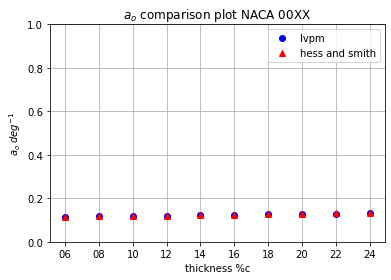

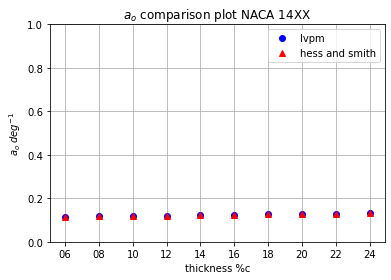

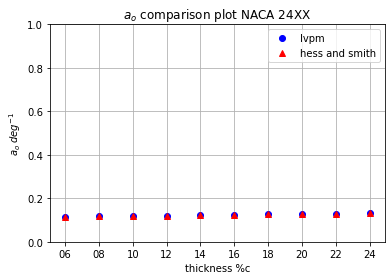

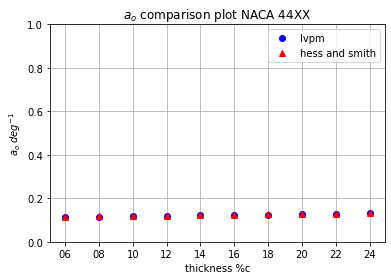

In [ ]:
lift_curve_slope()

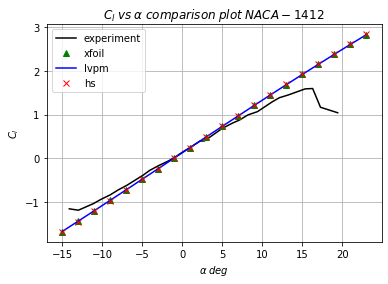

In [ ]:
#Comparing with experimental data
alpha=np.linspace(-15,23,20)
data1412=np.array([[19.426700 ,   1.04160000],[17.275600 ,   1.16678000],  [16.298400 ,   1.59387000],
  [15.363800  ,  1.58560000],  [13.230600  ,  1.44561000],  [12.132000 ,   1.38396000],  [11.192600   , 1.28391000],
  [ 9.409510  ,  1.06710000],   [8.213260  ,   .99207100],   [7.176200  ,   .87698400],  [ 6.302400  ,   .80693600],
   [5.039350  ,   .68850400],   [4.163470  ,   .57673000],   [2.800870  ,   .40155100],   [2.220010   ,  .39488200],
   [1.019990   ,  .25138800],  [  .144680   ,  .15627600],  [ -.958319  ,   .02111030],  [-1.768670  ,  -.06233150],
  [-2.967180  ,  -.16581000],  [-4.036770  ,  -.27096200],  [-4.913240  ,  -.38612600],  [-5.886350  ,  -.49629400],
  [-6.924440  ,  -.61481400],  [-7.994220  ,  -.71832500],  [-8.967510  ,  -.82851200], [-10.166700  ,  -.93538400],
 [-11.074900  , -1.02889000], [-12.954300  , -1.17922000], [-14.083500  , -1.14761000]])

data2412=np.array([[ 20.437000 ,   1.13378000],  [18.246800  ,  1.20896000],  [16.312200  ,  1.50956000],  [15.796700  ,  1.56509000],
  [15.281500  ,  1.59448000],  [14.220000  ,  1.52753000],  [12.064400  ,  1.39849000],  [10.004900  ,  1.24328000],
  [ 7.976970  ,  1.04388000],   [5.851670  ,   .85585500],  [ 3.757740  ,   .64812800],  [ 1.663040  ,  .45668300],
   [-.174796  ,   .24551800],  [-2.303350  ,   .04736980], [ -4.207400  ,  -.18035100],  [-6.434330  ,  -.37538700],
  [-8.436870  ,  -.60493700]])

data4412=np.array([[20.229500  ,  1.26552000],  [18.311000  ,  1.32971000],  [16.136700  ,  1.39720000],  [15.114200  ,  1.45971000],
  [14.059700  ,  1.51892000],  [13.324000  ,   1.53047000],  [11.817300  ,  1.43523000],  [ 9.733940  ,  1.32522000],
  [ 7.713040  ,  1.16753000],  [ 1.998180  ,   .60714800],  [-2.338590  ,   .16159900],  [-4.170820  ,  -.04726520],
  [-8.284480  ,  -.45685900]])

datax1412=np.array([[-15,	-1.6682],[-13	,-1.4327],[-11	,-1.1954],[-9	,-0.9567],[-7	,-0.7168],[-5,	-0.476],[-3,	-0.2347],
[-1,	0.0069],[1	,0.2485],[3	,0.4898],[5	,0.7305],[7	,0.9704],[9	,1.209],[11,	1.4462],[13,	1.6816],
[15,	1.915],[17,	2.146],[19,	2.3745],[21,	2.6],[23,	2.8224]])

datax2412=np.array([[-15,	-1.5448],[-13	,-1.3082],[-11	,-1.07],[-9	,-0.8306],[-7	,-0.5901],[-5,	-0.3488],[-3,	-0.1072],
[-1,	0.1345],[1,	0.3761],[3	,0.6173],[5	,0.8577],[7	,1.097],[9	,1.335],[11,	1.5714],[13,	1.8059],
[15,	2.0382],[17,	2.268],[19,	2.495],[21,	2.719],[23,	2.9398]])

datax4412=np.array([[-15	,-1.2988],[-13	,-1.0601],[-11,	-0.8201],[-9,	-0.5791],[-7,	-0.3374],[-5,	-0.0953],[-3,	0.1469],
[-1,	0.3889],[1	,0.6305],[3	,0.8712],[5,	1.111],[7,	1.3493],[9	,1.5861],[11,	1.8208],[13,	2.0534],[15,	2.2835],
[17,	2.5108],[19,	2.7351],[21,	2.956],[23,	3.1734]])
plt.figure(10)
plt.plot(data1412[:,0],data1412[:,1],'k-',datax1412[:,0],datax1412[:,1],'g^')
plt.plot(alpha,c_l1[1][3][:],'b')
plt.plot(alpha,c_l2[1][3][:],'rx')
plt.legend(['experiment','xfoil','lvpm','hs'])
plt.title(r'$C_l\;vs\;\alpha \;comparison\;plot \;NACA-1412$')
plt.xlabel(r'$\alpha\;deg$')
plt.ylabel(r'$C_l$')
plt.grid(True)

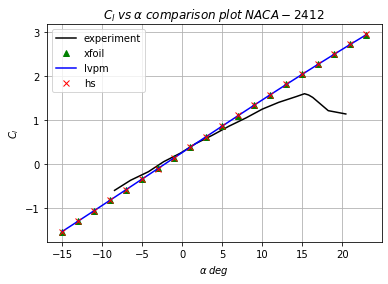

In [ ]:
plt.figure(11)
plt.plot(data2412[:,0],data2412[:,1],'k-',datax2412[:,0],datax2412[:,1],'g^')
plt.plot(alpha,c_l1[2][3][:],'b')
plt.plot(alpha,c_l2[2][3][:],'rx')
plt.legend(['experiment','xfoil','lvpm','hs'])
plt.title(r'$C_l\;vs\;\alpha \;comparison\;plot \;NACA-2412$')
plt.xlabel(r'$\alpha\;deg$')
plt.ylabel(r'$C_l$')
plt.grid(True)

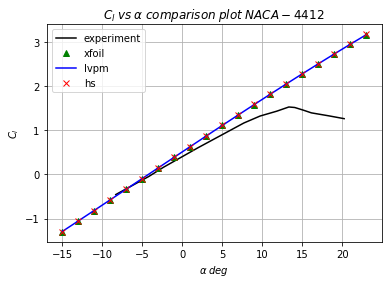

In [ ]:
plt.figure(12)
plt.plot(data4412[:,0],data4412[:,1],'k-',datax4412[:,0],datax4412[:,1],'g^')
plt.plot(alpha,c_l1[3][3][:],'b')
plt.plot(alpha,c_l2[3][3][:],'rx')
plt.legend(['experiment','xfoil','lvpm','hs'])
plt.title(r'$C_l\;vs\;\alpha \;comparison\;plot \;NACA-4412$')
plt.xlabel(r'$\alpha\;deg$')
plt.ylabel(r'$C_l$')
plt.grid(True)
plt.show()


<ipython-input-15-5a5322f41240>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().spines['left'].set_position(('data',0))
<ipython-input-15-5a5322f41240>:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().spines['bottom'].set_position(('data',0))
<ipython-input-15-5a5322f41240>:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance. 

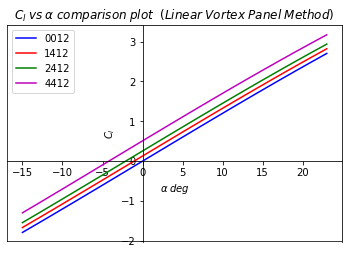

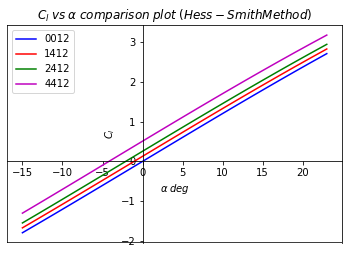

In [ ]:
plt.figure(13)
plt.plot(alpha,c_l1[0][3][:],'b')
plt.plot(alpha,c_l1[1][3][:],'r')
plt.plot(alpha,c_l1[2][3][:],'g')
plt.plot(alpha,c_l1[3][3][:],'m')
plt.title(r'$C_l\;vs\;\alpha \;comparison\;plot\; \ (Linear \;Vortex\; Panel\; Method) $')
plt.legend(['0012','1412','2412','4412'])
plt.xlabel(r'$\alpha\;deg$')
plt.ylabel(r'$C_l$')
plt.axes().spines['left'].set_position(('data',0))
plt.axes().spines['bottom'].set_position(('data',0))
plt.axhline(y=plt.ylim()[0],color='k')
plt.axvline(x=plt.xlim()[0],color='k')



plt.figure(14)
plt.plot(alpha,c_l2[0][3][:],'b')
plt.plot(alpha,c_l2[1][3][:],'r')
plt.plot(alpha,c_l2[2][3][:],'g')
plt.plot(alpha,c_l2[3][3][:],'m')
plt.title(r'$C_l\;vs\;\alpha \;comparison\;plot\; (Hess-Smith Method) $')
plt.legend(['0012','1412','2412','4412'])
plt.xlabel(r'$\alpha\;deg$')
plt.ylabel(r'$C_l$')
plt.axes().spines['left'].set_position(('data',0))
plt.axes().spines['bottom'].set_position(('data',0))
plt.axhline(y=plt.ylim()[0],color='k')
plt.axvline(x=plt.xlim()[0],color='k')





###Results:

<ol><li>It is observed that,for a $given\; thickness$ ,varying the $camber$(value and location) will affect the $\alpha_{l=0}$ which is represented in above plots. 

<li> However, for a given $camber$(value and location) lets say 24XX, on increasing the $thickness$ will increase the $a_o$ "but not" the $\alpha_{l=0}$

<li>$\alpha_{L=0}$ values almost matches with experimental data.
<li>$a_{o}$ values almost matches with experimental data.


###Discussion:


1) This section of the code compares the lift coefficients from the inviscid solutions obtained from PANEL methods and that of experimental data from Abbott and von Doenhof.

2) Agreement in the results  is good at low angles of attack, where the flow is fully attached. The agreement deteriorates as the
angle of attack increases, and viscous effects start to show up as a reduction in lift with increasing angle of attack, until, finally, the airfoil stalls. The inviscid solutions from PANEL methods cannot capture
this part of the physics.

3) C_l vs alpha curve is linear curve.

4) In thin airfoil theory, LVPM or HS method we assume there is no viscosity and flow separation hence there will be no wake region formed behind the body. According to kutta condition the flow will be attached till the trailing edge. But in practical cases the viscosity will affect flow around the body which may first lead to flow separartion and then wake region.


#**Part-4** (Comparison of results based on Number of panels chosen)
Note:Bonus Part: is included in Part-3  for the ease of results arrangment. 
1) The following piece of code is to just show the results of Cl vs alpha on a specific NACA 6509 aerofoil by varying the number of panels under consideration. This small solution is just to analyse the results visually. 

2) The exact variations in results due to the increase in Number of panels is however not pondered upon.
 
3) If the user would like to change the number of panels considered he/she may please change the values in the 4th line of the cell (n=np.array([10,20,40]). We have considered the Number of panels as 10,20,40. They maybe changed as wished. 

4) The results by varying the number of panels have a clear difference and it is opined by the group that by increasing the number of panels, more accurate results will be obtained.

c_p__i is :  [ 0.50085452  0.17149648 -0.00935375 -0.57155812 -2.14214291  0.99519373
  0.24042965 -0.1858413  -0.21342048  0.47669425]
c_p__i is :  [ 0.47520414  0.18643283  0.03012204 -0.46104751 -1.67042998  0.99394758
  0.12544527 -0.26002411 -0.24860604  0.42978567]
c_p__i is :  [ 0.44961939  0.20229503  0.07006204 -0.35271255 -1.23384266  0.94943319
  0.00359027 -0.33474829 -0.28262666  0.3816465 ]
c_p__i is :  [ 0.42416767  0.21904128  0.11036102 -0.24683863 -0.83353116  0.86176783
 -0.12481432 -0.40981696 -0.31539271  0.33240355]
c_p__i is :  [ 0.39891604  0.23662747  0.15091281 -0.1437047  -0.47055009  0.73118246
 -0.25943021 -0.48503235 -0.34681788  0.28218656]
c_p__i is :  [ 0.37393102  0.25500727  0.19161058 -0.04358245 -0.14585575  0.55802111
 -0.39990276 -0.56019632 -0.37681936  0.23112783]
c_p__i is :  [ 0.34927843  0.27413224  0.23234711  0.05326433  0.13969645  0.34273998
 -0.54586189 -0.63511083 -0.40531812  0.17936187]
c_p__i is :  [ 0.32502323  0.29395202  0.2730150

<ipython-input-16-39f8ef5e2104>:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().spines['left'].set_position(('data',0))
<ipython-input-16-39f8ef5e2104>:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().spines['bottom'].set_position(('data',0))
<ipython-input-16-39f8ef5e2104>:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance. 

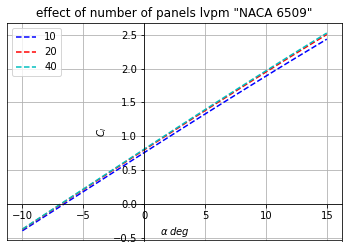

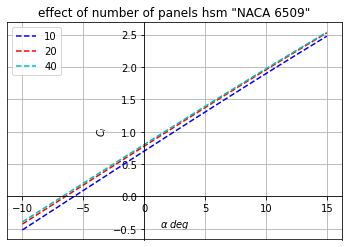

In [ ]:
airfoil=Nacaxxxx("6509")
cl_1=np.zeros((3,18))
cl_2=np.zeros((3,18))
n=np.array([10,20,40])
alpha=np.linspace(-10,15,18)
a,b=0,0
for i in range(0,3):
    pfoil1=Vortex_panel_2D(n[i],airfoil.z_u,airfoil.z_l)
    pfoil2=Hess_smith(n[i],airfoil.z_u,airfoil.z_l)
    for j in range(0,18):
        cl_1[i][j],a,b=pfoil1.solve(alpha[j]*np.pi/180)
        cl_2[i][j],a,b=pfoil2.solve(alpha[j]*np.pi/180)

plt.figure(1)
plt.plot(alpha,cl_1[0],'b--',alpha,cl_1[1],'r--',alpha,cl_1[2],'c--')
#plt.ylim(0,1.5)
plt.legend(['10','20','40'])
plt.xlabel(r'$\alpha\;deg$')
plt.ylabel(r'$C_l$')
plt.title('effect of number of panels lvpm "NACA 6509"')
plt.grid(True)
plt.axes().spines['left'].set_position(('data',0))
plt.axes().spines['bottom'].set_position(('data',0))
plt.axhline(y=plt.ylim()[0],color='k')
plt.axvline(x=plt.xlim()[0],color='k')

plt.figure(2)
plt.plot(alpha,cl_2[0],'b--',alpha,cl_2[1],'r--',alpha,cl_2[2],'c--')
#plt.ylim(0,1.5)
plt.legend(['10','20','40'])
plt.xlabel(r'$\alpha\;deg$')
plt.ylabel(r'$C_l$')
plt.title('effect of number of panels hsm "NACA 6509"')
plt.grid(True)
plt.axes().spines['left'].set_position(('data',0))
plt.axes().spines['bottom'].set_position(('data',0))
plt.axhline(y=plt.ylim()[0],color='k')
plt.axvline(x=plt.xlim()[0],color='k')

plt.show()